# Exploration and plot generation
This notebook generates many plots based on spells and spells_21_days.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import chain
from collections import Counter
import re
import seaborn as sns  # for easier grouped histogram
import numpy as np

base = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50/")


# --- Load data ---
input_suffix = "_sample1M"
output_suffix = "_sample1M_grace15_minspell7_ae_censoring"
opioid_flag = True
if opioid_flag:
    input_suffix = "_opioid" + input_suffix
    output_suffix = "_opioid" + output_suffix
spells = pd.read_parquet(base / f"spells_with_labels{output_suffix}.parquet")
split_spells = pd.read_parquet(base / f"split_spells{output_suffix}.parquet")

# Filter out rows with len(drug_combo) < 3
split_spells = split_spells[split_spells["drug_combo"].map(len) >= 3]

# rx_fills = pd.read_parquet(base / f"rx_fills{input_suffix}.parquet")
demographics = pd.read_parquet(base / f"demographics{input_suffix}.parquet")
comorbidities = pd.read_parquet(base / f"icd10_codes_from_spells{output_suffix}_clustered.parquet")
try:
    drug_changes = pd.read_parquet(base / f"drug_changes{output_suffix}.parquet")
except FileNotFoundError:
    print("Drug changes file not found.")
    drug_changes = pd.DataFrame()

In [2]:
drug_changes['spell_id'].nunique()

177488

📊 Summary of Gaps Between Spells (raw_exit → next entry)
-----------------------------------------------------------------
Version   |   Mean   Median   Std   Min   Max   Count
-----------------------------------------------------------------
15 days   | 198.06    74.00  315.23    16    3678   74,510
-----------------------------------------------------------------


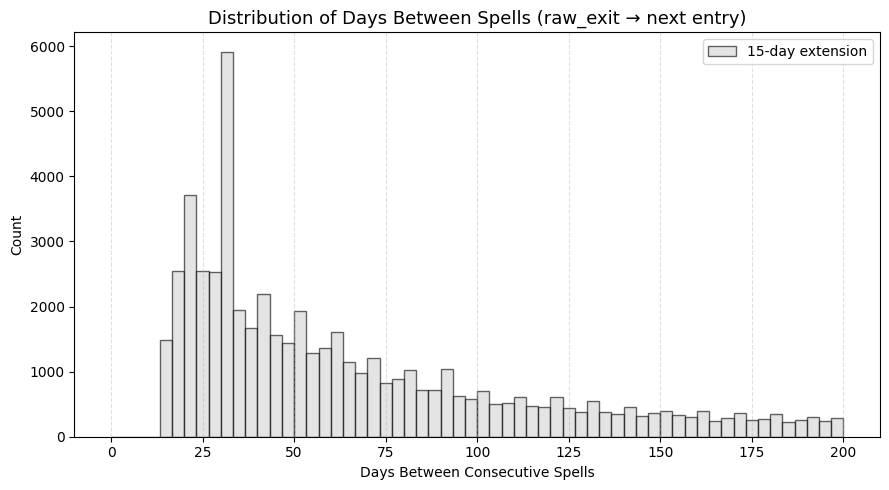

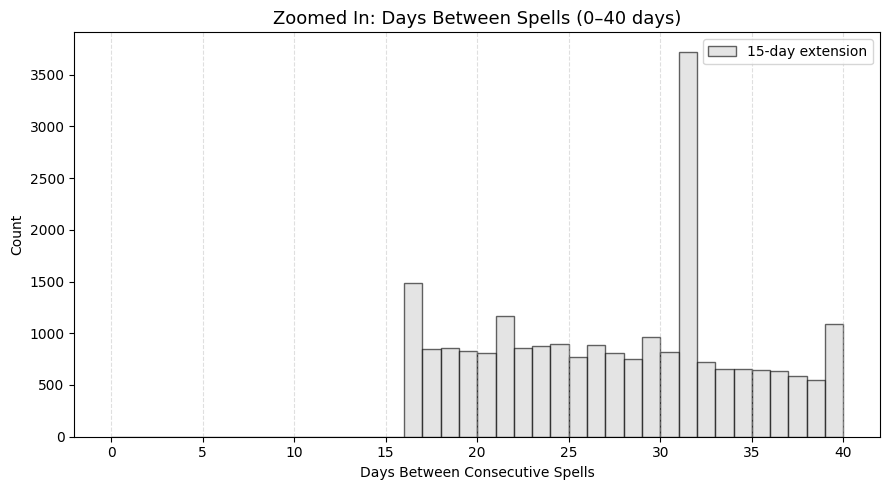

In [3]:
# --- Compare Gap Between Spells (15-day vs 21-day extensions) ---
def compute_gaps(spells_df):
    """Compute gap in days between consecutive spells for each patient."""
    # Ensure datetime types
    date_cols = ["entry_date", "raw_exit_date", "extended_exit_date", "followup_end_date"]
    for col in date_cols:
        if not np.issubdtype(spells_df[col].dtype, np.datetime64):
            spells_df[col] = pd.to_datetime(spells_df[col])
    
    # Sort and compute gap between raw_exit_date of previous spell and next entry_date
    spells_sorted = spells_df.sort_values(["MemberUID", "entry_date"]).copy()
    spells_sorted["days_since_prev_raw_exit"] = (
        spells_sorted["entry_date"] - spells_sorted.groupby("MemberUID")["raw_exit_date"].shift(1)
    ).dt.days
    
    return spells_sorted["days_since_prev_raw_exit"].dropna()

# Compute gaps for both versions
gaps = compute_gaps(spells)

# --- Summary stats ---
print("📊 Summary of Gaps Between Spells (raw_exit → next entry)")
print("-" * 65)
print("Version   |   Mean   Median   Std   Min   Max   Count")
print("-" * 65)
print(f"15 days   | {gaps.mean():6.2f}  {gaps.median():7.2f}  {gaps.std():6.2f}  {gaps.min():4.0f}  {gaps.max():6.0f}  {len(gaps):7,}")
print("-" * 65)

# --- Plot full histogram (0–200 days for clarity) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=60, range=(0, 200), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Distribution of Days Between Spells (raw_exit → next entry)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --- Zoomed-in histogram (0–40 days) ---
plt.figure(figsize=(9, 5))
plt.hist(gaps, bins=40, range=(0, 40), alpha=0.6, label="15-day extension", color="lightgray", edgecolor="black")
plt.title("Zoomed In: Days Between Spells (0–40 days)", fontsize=13)
plt.xlabel("Days Between Consecutive Spells")
plt.ylabel("Count")
plt.legend()
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

In [3]:
# --- 🧮 Spell summary comparison Split vs non-split---

def summarize_spells(df):
    """Get spell summary statistics."""
    total = len(df)
    one_per = len(df.drop_duplicates(subset=["MemberUID"], keep="first"))
    return total, one_per, one_per / total * 100

# Summaries
total, one, pct = summarize_spells(spells)
total_split, one_split, pct_split = summarize_spells(split_spells)


print("📊 Spell Summary Comparison")
print("-" * 60)
print(f"{'Config':<20}{'Total Spells':>15}{'1/Patient':>15}{'% of Total':>10}")
print("-" * 60)
print(f"{'Spells':<20}{total:>15,}{one:>15,}{pct:>9.2f}%")
print(f"{'Split Spells':<20}{total_split:>15,}{one_split:>15,}{pct_split:>9.2f}%")
print("-" * 60)

# Keep only the one-per-patient spells for further analysis
# spells = spells.drop_duplicates(subset=["MemberUID"], keep="first")


📊 Spell Summary Comparison
------------------------------------------------------------
Config                 Total Spells      1/Patient% of Total
------------------------------------------------------------
Spells                      126,940         47,802    37.66%
Split Spells                316,173         44,860    14.19%
------------------------------------------------------------



📋 Top Adverse Event Codes and Descriptions
--------------------------------------------------------------------------------
CodeValue  count                                                                                         Description  % of Total
    F1120    750                                              Mental and behavioural disorders due to use of opioids       35.63
    F1190    201                                              Mental and behavioural disorders due to use of opioids        9.55
  T7840XA    179                                                            Adverse effects not elsewhere classified        8.50
    F1920    120  Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances        5.70
  T451X5A    119       Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances        5.65
  T402X5A    115       Poisoning by adverse effect of and underdosing of drugs medicaments and biolog

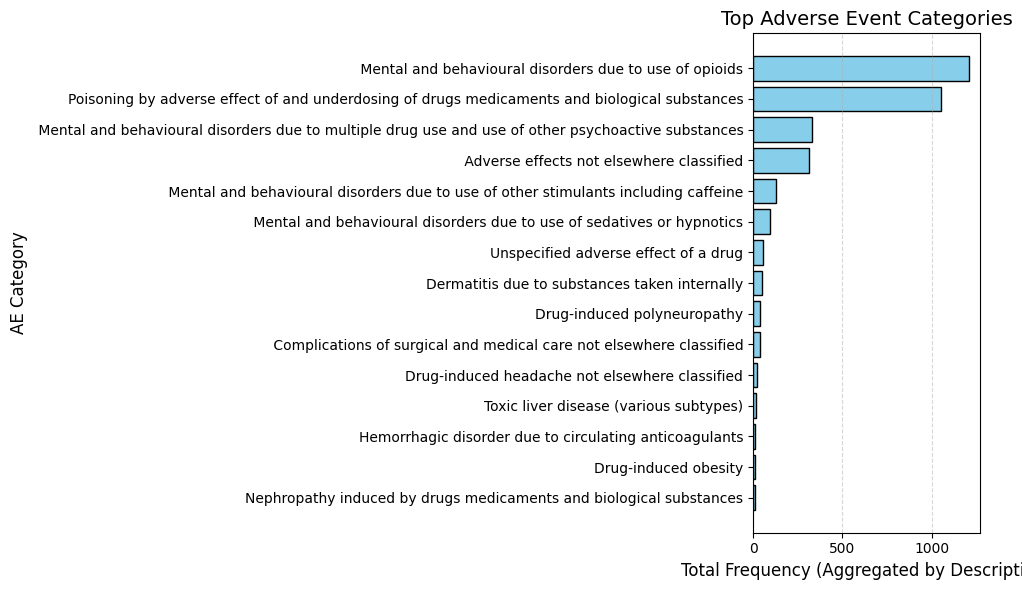


🧮 Aggregated AE Category Counts (for plot)
                                                                                        Description  count
                                             Mental and behavioural disorders due to use of opioids   1211
      Poisoning by adverse effect of and underdosing of drugs medicaments and biological substances   1055
 Mental and behavioural disorders due to multiple drug use and use of other psychoactive substances    329
                                                           Adverse effects not elsewhere classified    315
                 Mental and behavioural disorders due to use of other stimulants including caffeine    126
                              Mental and behavioural disorders due to use of sedatives or hypnotics     93
                                                               Unspecified adverse effect of a drug     55
                                                      Dermatitis due to substances taken internally 

In [8]:
# --- ⚙️ Flatten AE codes across all AE spells ---
# If 'first_ae_code' doesn’t exist, replace it with your AE column (e.g. 'ae_codes')
ae_freq_df = (
    split_spells[split_spells["had_ae"]]["first_ae_code"]
    .value_counts()
    .reset_index()
    .rename(columns={"first_ae_code": "CodeValue"})
)

# --- 📖 Read mapping CSV (with lazy SQL-like patterns) ---
ae_map = pd.read_csv("data/icd10_codes.csv")  # columns: code, description

def map_description(code):
    """Return AE description using SQL-like % wildcards."""
    for _, row in ae_map.iterrows():
        pattern = row["code"].replace("%", "")
        if str(code).startswith(pattern):
            return row["description"]
    return "Unknown AE code"

# Map descriptions
ae_freq_df["Description"] = ae_freq_df["CodeValue"].apply(map_description)

# --- 📊 Summary Table of Top AE Codes ---
top_n = 15
top_ae_df = ae_freq_df.head(top_n).copy()
top_ae_df["% of Total"] = (
    top_ae_df["count"] / top_ae_df["count"].sum() * 100
).round(2)

print("\n📋 Top Adverse Event Codes and Descriptions")
print("-" * 80)
print(top_ae_df.to_string(index=False))
print("-" * 80)
print(f"Showing top {top_n} AE categories out of {len(ae_freq_df):,} total unique codes.\n")

# --- 🔢 Aggregate by Description for visualization ---
agg_by_desc = (
    ae_freq_df.groupby("Description", as_index=False)["count"]
    .sum()
    .sort_values("count", ascending=False)
)

# Take top N descriptions for plotting
top_desc = agg_by_desc.head(top_n)

# --- 🎨 Visualization ---
plt.figure(figsize=(10, 6))
plt.barh(top_desc["Description"], top_desc["count"], color="skyblue", edgecolor="black")
plt.gca().invert_yaxis()  # Highest on top
plt.title("Top Adverse Event Categories", fontsize=14)
plt.xlabel("Total Frequency (Aggregated by Description)", fontsize=12)
plt.ylabel("AE Category", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# --- 🧮 Print small summary of aggregation ---
print("\n🧮 Aggregated AE Category Counts (for plot)")
print(top_desc.to_string(index=False))

print("Total Adverse Events Counted:", ae_freq_df["count"].sum())


📊 AE Positioning Within Spell
--------------------------------------------------
count    3796.000000
mean      107.433351
std       196.588875
min         0.000000
25%        10.000000
50%        33.000000
75%       113.000000
max      2266.000000
Name: days_into_spell, dtype: float64


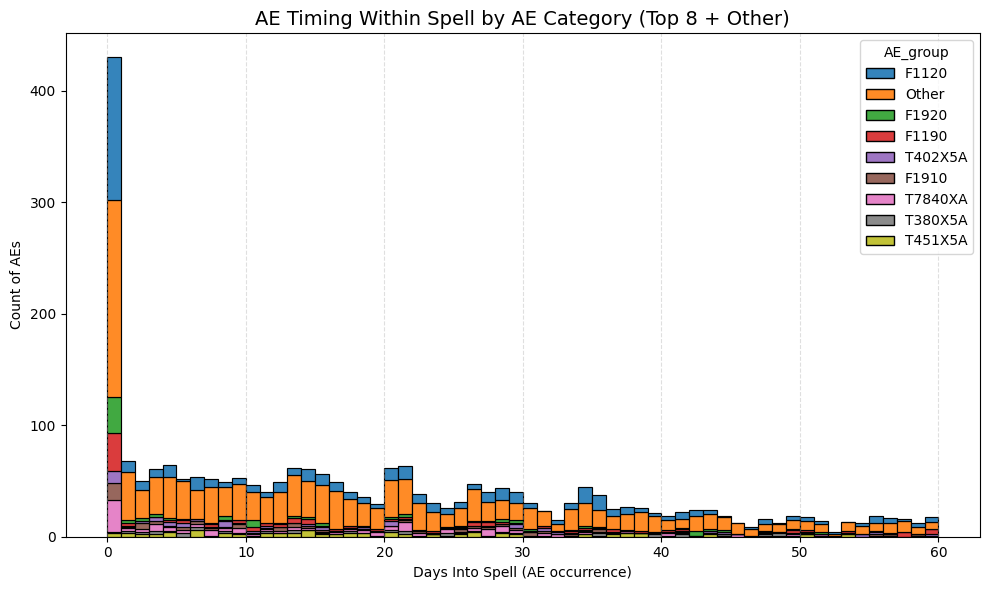

In [9]:
# --- 🧭 AE positioning within spell (days into spell) ---
ae_spells = spells[spells["had_ae"]].copy()

# Ensure datetime
ae_spells["entry_date"] = pd.to_datetime(ae_spells["entry_date"])
ae_spells["first_ae_date"] = pd.to_datetime(ae_spells["first_ae_date"])

# Compute days into spell
ae_spells["days_into_spell"] = (ae_spells["first_ae_date"] - ae_spells["entry_date"]).dt.days

# --- 📊 Summary ---
print("\n📊 AE Positioning Within Spell")
print("-" * 50)
print(ae_spells["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (based on frequency of first_ae_code) ---
top_n = 8
top_codes = (
    ae_spells["first_ae_code"]
    .value_counts()
    .head(top_n)
    .index
    .tolist()
)

# Create a grouped category column
ae_spells["AE_group"] = ae_spells["first_ae_code"].apply(
    lambda x: x if x in top_codes else "Other"
)

# --- 🎨 Plot histogram coloured by AE category ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ae_spells,
    x="days_into_spell",
    hue="AE_group",
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9
)
plt.title("AE Timing Within Spell by AE Category (Top 8 + Other)", fontsize=14)
plt.xlabel("Days Into Spell (AE occurrence)")
plt.ylabel("Count of AEs")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


📊 AE Positioning Within Spell
--------------------------------------------------
count    3433.000000
mean       14.319837
std        24.371749
min         0.000000
25%         0.000000
50%         7.000000
75%        19.000000
max       470.000000
Name: days_into_spell, dtype: float64


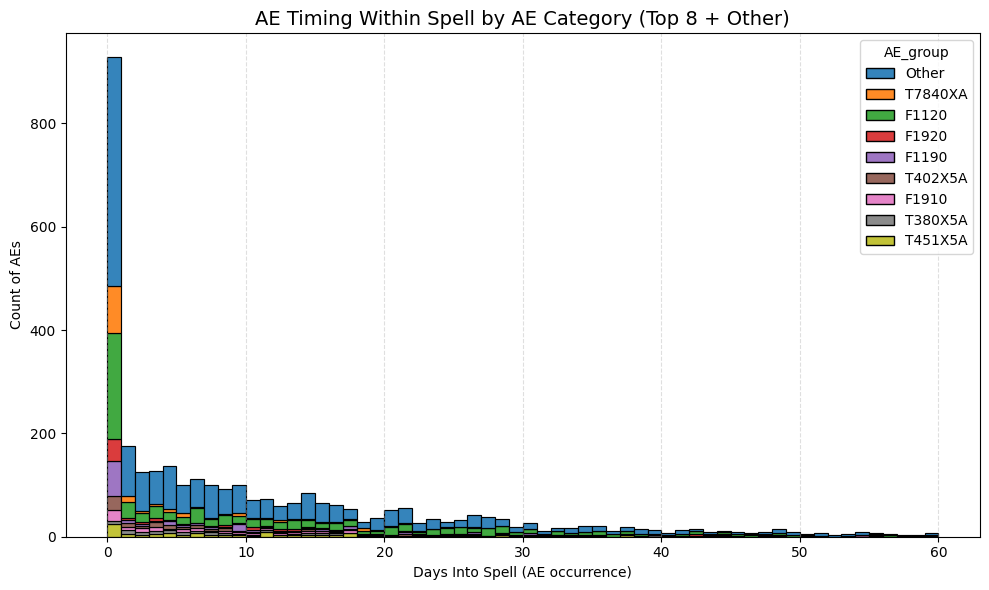

In [10]:
# --- 🧭 AE positioning within split_spells (days into spell) ---
ae_spells_split = split_spells[split_spells["had_ae"]].copy()

# Ensure datetime
ae_spells_split["entry_date"] = pd.to_datetime(ae_spells_split["entry_date"])
ae_spells_split["first_ae_date"] = pd.to_datetime(ae_spells_split["first_ae_date"])

# Compute days into spell
ae_spells_split["days_into_spell"] = (ae_spells_split["first_ae_date"] - ae_spells_split["entry_date"]).dt.days

# --- 📊 Summary ---
print("\n📊 AE Positioning Within Spell")
print("-" * 50)
print(ae_spells_split["days_into_spell"].describe())

# --- 🧩 Identify top AE categories (based on frequency of first_ae_code) ---
top_n = 8
top_codes = (
    ae_spells_split["first_ae_code"]
    .value_counts()
    .head(top_n)
    .index
    .tolist()
)

# Create a grouped category column
ae_spells_split["AE_group"] = ae_spells_split["first_ae_code"].apply(
    lambda x: x if x in top_codes else "Other"
)

# --- 🎨 Plot histogram coloured by AE category ---
plt.figure(figsize=(10, 6))
sns.histplot(
    data=ae_spells_split,
    x="days_into_spell",
    hue="AE_group",
    bins=60,
    binrange=(0, 60),
    multiple="stack",
    edgecolor="black",
    alpha=0.9
)
plt.title("AE Timing Within Spell by AE Category (Top 8 + Other)", fontsize=14)
plt.xlabel("Days Into Spell (AE occurrence)")
plt.ylabel("Count of AEs")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

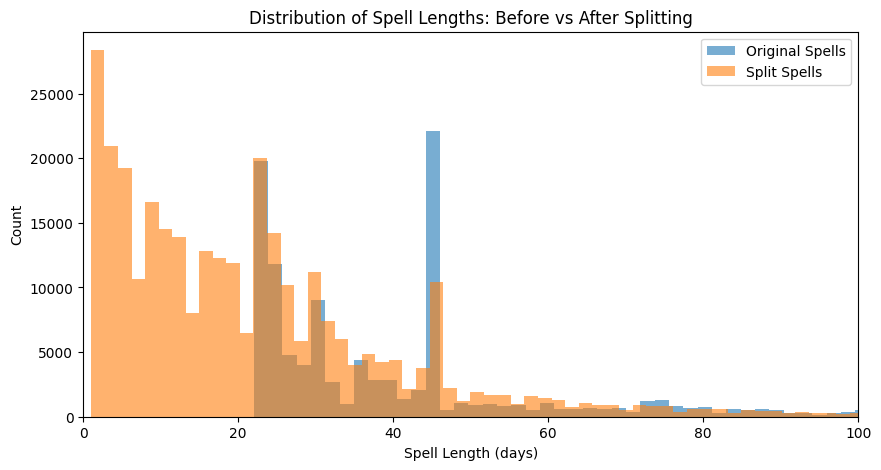

Original Spells Summary:
count    126940.000000
mean         73.800937
std         131.306449
min          22.000000
25%          26.000000
50%          41.000000
75%          60.000000
max        3718.000000
Name: spell_length_days, dtype: float64

Split Spells Summary:
count    316173.000000
mean         23.824798
std          25.490008
min           1.000000
25%           7.000000
50%          19.000000
75%          30.000000
max         875.000000
Name: spell_length_days, dtype: float64


In [13]:
# --- 1. Distribution of spell lengths before and after splitting ---

import matplotlib.pyplot as plt

# Original spell lengths
spell_lengths = spells['spell_length_days']

# Split spell lengths
split_spell_lengths = split_spells['spell_length_days']

# Plot
plt.figure(figsize=(10,5))
plt.hist(spell_lengths, bins=2000, alpha=0.6, label='Original Spells')
plt.hist(split_spell_lengths, bins=500, alpha=0.6, label='Split Spells')
plt.xlabel('Spell Length (days)')
plt.ylabel('Count')
plt.xlim(0, 100)  # Set x-axis limits
plt.title('Distribution of Spell Lengths: Before vs After Splitting')
plt.legend()
plt.show()

# Summary statistics
print("Original Spells Summary:")
print(spell_lengths.describe())
print("\nSplit Spells Summary:")
print(split_spell_lengths.describe())


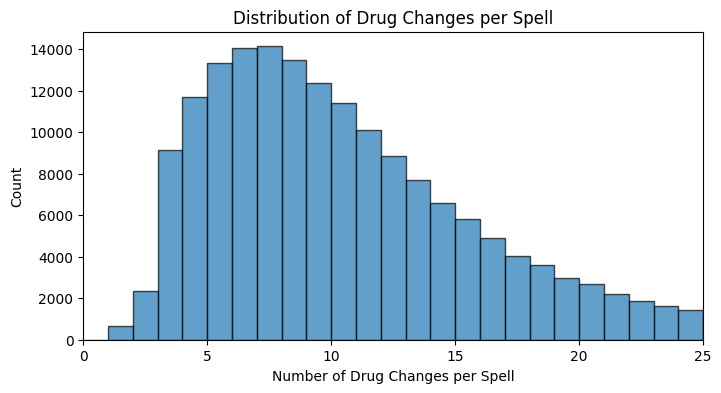

count    177488.000000
mean         11.410315
std           9.502742
min           1.000000
25%           6.000000
50%           9.000000
75%          14.000000
max         869.000000
dtype: float64


In [14]:
# --- 2. Distribution of number of drug changes per spell ---

# Count drug changes per spell_id
drug_changes_per_spell = (
    drug_changes[drug_changes['change_type'] == 'add']
        .groupby('spell_id')
        .size()
)
# Plot
plt.figure(figsize=(8,4))
plt.hist(drug_changes_per_spell, bins=range(0, drug_changes_per_spell.max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Number of Drug Changes per Spell')
plt.ylabel('Count')
plt.xlim(0, 25)  # Focus on 0-20 range for clarity
plt.title('Distribution of Drug Changes per Spell')
plt.show()

# Summary statistics
print(drug_changes_per_spell.describe())


# Remove drops


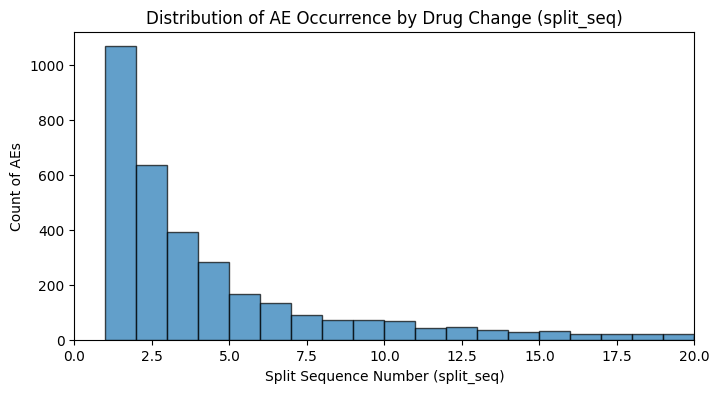

split_seq
1     1067
2      634
3      390
4      283
5      167
      ... 
72       1
75       1
79       1
89       1
96       1
Name: count, Length: 62, dtype: int64


In [15]:
# --- 3. At which drug change does AE occur (split_seq) ---

# Filter split spells that had an AE
ae_spells = split_spells[split_spells['had_ae'] == True]

# Distribution of AE occurrence by split_seq
plt.figure(figsize=(8,4))
plt.hist(ae_spells['split_seq'], bins=range(1, ae_spells['split_seq'].max()+2), edgecolor='black', alpha=0.7)
plt.xlabel('Split Sequence Number (split_seq)')
plt.ylabel('Count of AEs')
plt.xlim(0, 20)
plt.title('Distribution of AE Occurrence by Drug Change (split_seq)')
plt.show()

# Summary
print(ae_spells['split_seq'].value_counts().sort_index())


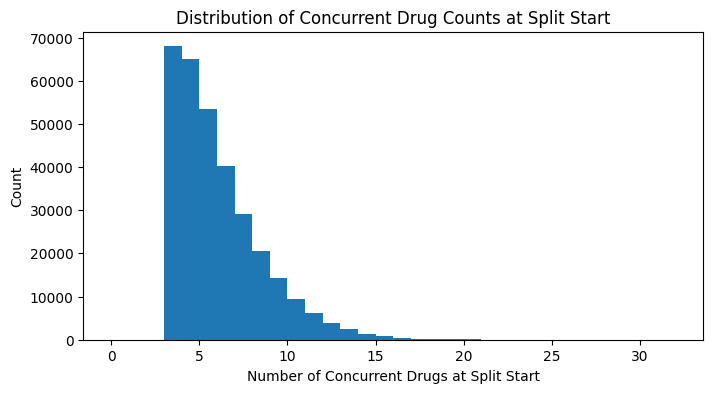

Most common 3-drug combos at split start:


,Drug Combo,Count
0,"(M01A, M03B, N02A)",1093
1,"(A02B, M01A, N02A)",939
2,"(M01A, N02A, N02B)",639
3,"(M01A, N02A, N06A)",526
4,"(M03B, N02A, N02B)",522
5,"(N02A, N02B, N06A)",480
6,"(N02A, N05B, N06A)",443
7,"(J01C, M01A, N02A)",407
8,"(M03B, N02A, N06A)",387
9,"(A02B, N02A, N06A)",355


Most common 4-drug combos at split start:


,Drug Combo,Count
0,"(M01A, M03B, N02A, N02B)",248
1,"(M01A, M03B, N02A, N06A)",180
2,"(H02A, M01A, M03B, N02A)",147
3,"(M03B, N02A, N02B, N06A)",147
4,"(A02B, M01A, M03B, N02A)",134
5,"(M01A, N02A, N02B, N06A)",120
6,"(N02A, N02B, N05B, N06A)",112
7,"(M03B, N02A, N05B, N06A)",108
8,"(A01A, A02B, M01A, N02A)",107
9,"(A02B, M01A, N02A, N02B)",103


Total distinct individual drugs across all splits: 193


In [16]:
# --- 4. Derive concurrent drug combos at split start ---

# Number of concurrent drugs at split start
split_spells["concurrent_drugs"] = split_spells["drug_combo"].apply(len)

# Simple histogram
plt.figure(figsize=(8, 4))
plt.hist(split_spells["concurrent_drugs"], bins=range(0, split_spells["concurrent_drugs"].max() + 2))
plt.xlabel("Number of Concurrent Drugs at Split Start")
plt.ylabel("Count")
plt.title("Distribution of Concurrent Drug Counts at Split Start")
plt.show()

# Show the most common drug combos for 3 concurrent drugs
three_drug_combos = split_spells[split_spells["concurrent_drugs"] == 3]["drug_combo"]
combo_counts = Counter(tuple(sorted(combo)) for combo in three_drug_combos)
common_codes = pd.DataFrame(
    combo_counts.most_common(10),
    columns=["Drug Combo", "Count"]
)
print("Most common 3-drug combos at split start:")
display(common_codes)

# Show the most common drug combos for 4 concurrent drugs
four_drug_combos = split_spells[split_spells["concurrent_drugs"] == 4]["drug_combo"]
combo_counts_4 = Counter(tuple(sorted(combo)) for combo in four_drug_combos)
common_codes_4 = pd.DataFrame(
    combo_counts_4.most_common(10),
    columns=["Drug Combo", "Count"]
)
print("Most common 4-drug combos at split start:")
display(common_codes_4)

# Number of distinct individual drugs across all splits
all_drugs = set(chain.from_iterable(split_spells["drug_combo"]))
print(f"Total distinct individual drugs across all splits: {len(all_drugs)}")

count    36781.000000
mean        30.030423
std         25.870299
min          1.000000
25%         12.000000
50%         22.000000
75%         40.000000
max        248.000000
Name: n_codes, dtype: float64

icd10_codes
I10    19328
M54    17438
Z79    17141
E78    16081
M25    15597
Z68    15239
M79    13749
Z01    13507
G89    11838
Z00    11479
Z12    11233
R10    11167
Z23    11145
F41    10902
K21    10297
E66    10138
R06     9684
Z87     9436
R07     9274
E11     9227
Name: count, dtype: int64

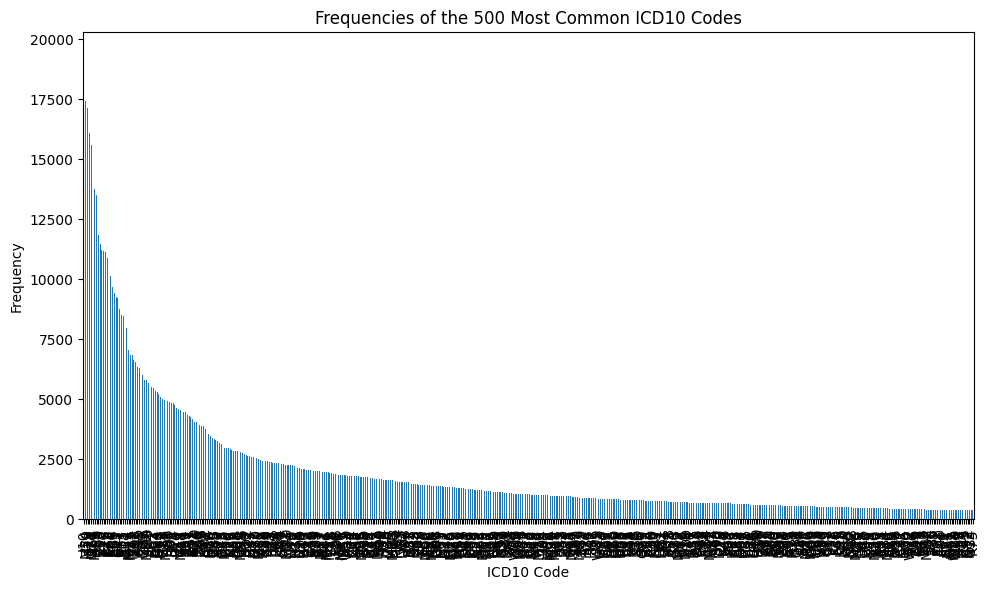

Total distinct ICD10 codes in dataset: 1872


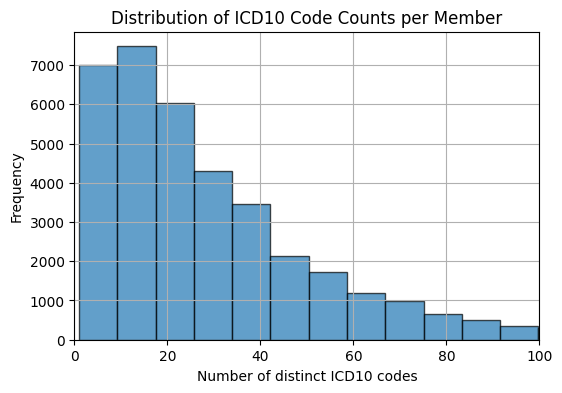

In [ ]:
# Show the comorbidities per patient
# Group by MemberUID and collapse to distinct ICD10 codes per member
member_icd = (
    comorbidities
    .explode("icd10_codes")               # one code per row
    .drop_duplicates(["MemberUID", "icd10_codes"])
)

# --- Descriptive statistics ---

# 1. Count of unique ICD10 codes per member
code_counts = (
    member_icd.groupby("MemberUID")["icd10_codes"]
    .nunique()
    .rename("n_codes")
)
display(code_counts.describe())

# 2. Most common ICD10 codes overall
common_codes = (
    member_icd["icd10_codes"]
    .value_counts()
    .head(20)
)
display(common_codes)

# Plot the frequencies of the 500 most common ICD10 codes
plt.figure(figsize=(10, 6))
common_500 = (
    member_icd["icd10_codes"]
    .value_counts()
    .head(500)
)
common_500.plot(kind='bar')
plt.title("Frequencies of the 500 Most Common ICD10 Codes")
plt.xlabel("ICD10 Code")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Amount of distinct ICD10 codes in all the dataset, no grouping per member
distinct_icd10_codes = member_icd["icd10_codes"].nunique()
print(f"Total distinct ICD10 codes in dataset: {distinct_icd10_codes}")


# 3. Distribution of number of codes per member
import matplotlib.pyplot as plt

# Suppress x-axis labels for clarity
plt.figure(figsize=(6,4))
code_counts.hist(bins=30, edgecolor='black', alpha=0.7)
plt.xlabel("Number of distinct ICD10 codes")
plt.ylabel("Frequency")
plt.xlim(0,100)
plt.title("Distribution of ICD10 Code Counts per Member")
plt.show()


In [21]:
# --- 👥 Demographics Comparison: AE vs Non-AE ---

ae_spells = split_spells[split_spells["had_ae"]].copy()

# Define AE and Non-AE members
ae_members = ae_spells["MemberUID"].unique()
non_ae_members = split_spells.loc[~split_spells["MemberUID"].isin(ae_members), "MemberUID"].unique()
ae_demo = demographics[demographics["MemberUID"].isin(ae_members)].copy()
non_ae_demo = demographics[demographics["MemberUID"].isin(non_ae_members)].copy()

print(f"\n📊 Demographics Summary")
print("-" * 60)
print(f"AE patients: {len(ae_demo):,}")
print(f"Non-AE patients: {len(non_ae_demo):,}")
print("-" * 60)

# --- Gender distribution ---
gender_ae = ae_demo["gendercode"].value_counts(normalize=True).rename("AE (%)") * 100
gender_non = non_ae_demo["gendercode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
gender_table = pd.concat([gender_ae, gender_non], axis=1).fillna(0).round(2)

# --- Race / Ethnicity distribution ---
race_ae = ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("AE (%)") * 100
race_non = non_ae_demo["raceethnicitytypecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
race_table = pd.concat([race_ae, race_non], axis=1).fillna(0).round(2)

# --- State distribution (Top 10 AE states) ---
state_ae = ae_demo["statecode"].value_counts(normalize=True).rename("AE (%)") * 100
state_non = non_ae_demo["statecode"].value_counts(normalize=True).rename("Non-AE (%)") * 100
# Restrict to top 10 AE states for clarity
top_states = state_ae.head(10).index
state_table = pd.concat([state_ae.loc[top_states], state_non.loc[top_states]], axis=1).fillna(0).round(2)

# --- Display results ---
print("\n🧍 Gender Distribution (% of group):")
print(gender_table.to_string())

print("\n🌎 Race / Ethnicity Distribution (% of group):")
print(race_table.to_string())


📊 Demographics Summary
------------------------------------------------------------
AE patients: 3,120
Non-AE patients: 41,740
------------------------------------------------------------

🧍 Gender Distribution (% of group):
            AE (%)  Non-AE (%)
gendercode                    
F            61.67       60.29
M            38.33       39.71
U             0.00        0.00

🌎 Race / Ethnicity Distribution (% of group):
                       AE (%)  Non-AE (%)
raceethnicitytypecode                    
09                      38.21       48.01
01                      36.79       28.68
02                      13.08       10.07
06                       5.58        5.58
11                       5.51        6.25
04                       0.83        1.42
